# Spectrogram classification
## 코드

1. 음성데이터를 2차원 Spectrogram 으로 변환하여 데이터셋을 구성하였다.  
스펙트로그램 시각화 및 train/test 데이터셋 구성이 정상진행되었다.  
<br>  

2. 1,2차원 데이터를 처리하는 음성인식 모델이 정상 작동한다.  
스펙트로그램을 입력받은 모델이 학습과정에서 안정적으로 수렴하며, evaluation/test 단계를 무리없이 진행가능하다.  
<br>  

3. 테스트셋 수행결과 음성인식 모델의 Accuracy가 일정 수준에 도달하였다.  
evaluation 결과 75% 이상의 정확도를 달성하는 모델이 하나 이상 존재한다.  

In [1]:
import os
import random
import numpy as np
import librosa
import librosa.display
import tensorflow as tf
import IPython.display as ipd
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


### 1. 데이터 처리와 분류

In [3]:
# 1-1. 라벨 데이터 처리하기
data_path = os.getenv("HOME") + '/aiffel/data/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

label_value = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value  # {'yes': 0, 'no': 1, 'up': 2, ...}

temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)  # array([ 3,  3,  3, ..., 11, 11, 11])

# 1-2. train, test분리
train_wav, test_wav, train_label, test_label = train_test_split(speech_data["wav_vals"], label_data, test_size=0.1, shuffle=True)

del speech_data

### 2. 학습을 위한 하이퍼파라미터 설정


In [19]:
batch_size = 32
max_epochs = 10

# the save point - 후에 모델체크포인트 callback함수를 설정하거나 모델을 불러올 때 사용
checkpoint_dir = os.getenv('HOME') + '/aiffel/data/speech_recognition/models/wav'
checkpoint_dir1 = os.getenv('HOME') + '/aiffel/data/speech_recognition/models1/wav'

### 3. 데이터셋 구성

In [5]:
# 3-1. 1차원의 Waveform 데이터를 2차원의 Spectrogram 데이터로 변환
def wav2spec(wav, fft_size=258):  # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))  # wav-파형의 amplitude 값, n_fft-win_length보다 길 경우 모두 zero padding해서 처리하기 위한 파라미터
    return D

def change_shape(waves):
    tmp_wav = []
    for wav in waves:
        tmp_wav.append(wav2spec(wav))
    return np.array(tmp_wav)

train_wav = change_shape(train_wav)  # (45558, 130, 126)
test_wav = change_shape(test_wav)    # (5062, 130, 126)

# 차원 1 -> 2
sr = 130
sc = 126
train_wav = train_wav.reshape(-1, sr, sc, 1)
test_wav = test_wav.reshape(-1, sr, sc, 1)
print(train_wav.shape, train_label.shape)  # (45558, 130, 126, 1) (45558,)
print(test_wav.shape, test_label.shape)    # (5062, 130, 126, 1) (5062,)

# 3-2. 데이터 설정
# map : dataset이 데이터를 불러올때마다 동작시킬 데이터 전처리 함수를 매핑해줌
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)

(45558, 130, 126, 1) (45558,)
(5062, 130, 126, 1) (5062,)


### 4. 모델 구성
- 2차원 Spectrogram 데이터의 시간축 방향으로 Conv1D layer를 적용, 혹은 Conv2D layer를 적용 가능
- batchnorm, dropout, dense layer 등을 이용
- 12개의 단어 class를 구분하는 loss를 사용하고 Adam optimizer를 사용
- 모델 가중치를 저장하는 checkpoint callback 함수 추가
- 다양한 모델의 실험을 진행해 보시기 바랍니다.

In [20]:
# model 1
input_tensor = layers.Input(shape=(130, 126, ))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav = tf.keras.Model(input_tensor, output_tensor)

model_wav.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  optimizer=tf.keras.optimizers.Adam(1e-4),
                  metrics=['accuracy'])

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir1,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [9]:
# model 2
input_tensor_x2 = layers.Input(shape=(sr, sc, 1))

x2 = layers.Conv2D(32, 3, padding='same', activation='relu')(input_tensor_x2)
x2 = layers.Conv2D(32, 3, padding='same', activation='relu')(x2)
skip_1_x2 = layers.MaxPool2D()(x2)

x2 = layers.Conv2D(64, 3, padding='same', activation='relu')(skip_1_x2)
x2 = layers.Conv2D(64, 3, padding='same', activation='relu')(x2)
x2 = tf.concat([x2, skip_1_x2], -1)
skip_2_x2 = layers.MaxPool2D()(x2)

x2 = layers.Conv2D(128, 3, padding='same', activation='relu')(skip_2_x2)
x2 = layers.Conv2D(128, 3, padding='same', activation='relu')(x2)
x2 = layers.Conv2D(128, 3, padding='same', activation='relu')(x2)
x2 = tf.concat([x2, skip_2_x2], -1)
skip_3_x2 = layers.MaxPool2D()(x2)

x2 = layers.Conv2D(256, 3, padding='same', activation='relu')(skip_3_x2)
x2 = layers.Conv2D(256, 3, padding='same', activation='relu')(x2)
x2 = layers.Conv2D(256, 3, padding='same', activation='relu')(x2)
x2 = tf.concat([x2, skip_3_x2], -1)
x2 = layers.MaxPool2D()(x2)
x2 = layers.Dropout(0.3)(x2)

x2 = layers.Flatten()(x2)
x2 = layers.Dense(256)(x2)
x2 = layers.BatchNormalization()(x2)
x2 = layers.Activation('relu')(x2)

output_tensor_x2 = layers.Dense(12)(x2)

model_wav_x2 = tf.keras.Model(input_tensor_x2, output_tensor_x2)

model_wav_x2.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                     optimizer=tf.keras.optimizers.Adam(1e-4),
                     metrics=['accuracy'])

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

### 5. 학습

In [21]:
# model 1
history_wav = model_wav.fit(train_dataset,
                            epochs=max_epochs,
                            steps_per_epoch=len(train_wav) // batch_size,
                            validation_data=test_dataset,
                            validation_steps=len(test_wav) // batch_size,
                            callbacks=[cp_callback]
                            )

Epoch 1/10
1421/1423 [============================>.] - ETA: 0s - loss: 1.3646 - accuracy: 0.5348
Epoch 00001: val_loss improved from inf to 0.92788, saving model to /home/ssac14/aiffel/data/speech_recognition/models1/wav
1423/1423 [==============================] - 10s 7ms/step - loss: 1.3640 - accuracy: 0.5350 - val_loss: 0.9279 - val_accuracy: 0.6887
Epoch 2/10
1419/1423 [============================>.] - ETA: 0s - loss: 0.6755 - accuracy: 0.7760
Epoch 00002: val_loss improved from 0.92788 to 0.54679, saving model to /home/ssac14/aiffel/data/speech_recognition/models1/wav
1423/1423 [==============================] - 9s 7ms/step - loss: 0.6750 - accuracy: 0.7762 - val_loss: 0.5468 - val_accuracy: 0.8159
Epoch 3/10
1415/1423 [============================>.] - ETA: 0s - loss: 0.4530 - accuracy: 0.8483
Epoch 00003: val_loss improved from 0.54679 to 0.45705, saving model to /home/ssac14/aiffel/data/speech_recognition/models1/wav
1423/1423 [==============================] - 9s 7ms/step - 

In [11]:
# model 2
history_wav_2 = model_wav_x2.fit(train_dataset,
                                 epochs=max_epochs,
                                 steps_per_epoch=len(train_wav) // batch_size,
                                 validation_data=test_dataset,
                                 validation_steps=len(test_wav) // batch_size,
                                 callbacks=[cp_callback]
                                )

Epoch 1/10
1422/1423 [============================>.] - ETA: 0s - loss: 0.8186 - accuracy: 0.7375
Epoch 00001: val_loss did not improve from 0.25975
1423/1423 [==============================] - 66s 46ms/step - loss: 0.8183 - accuracy: 0.7375 - val_loss: 0.3332 - val_accuracy: 0.8928
Epoch 2/10
1422/1423 [============================>.] - ETA: 0s - loss: 0.2731 - accuracy: 0.9174
Epoch 00002: val_loss improved from 0.25975 to 0.22144, saving model to /home/ssac14/aiffel/data/speech_recognition/models/wav
1423/1423 [==============================] - 67s 47ms/step - loss: 0.2730 - accuracy: 0.9174 - val_loss: 0.2214 - val_accuracy: 0.9250
Epoch 3/10
1422/1423 [============================>.] - ETA: 0s - loss: 0.1762 - accuracy: 0.9478
Epoch 00003: val_loss improved from 0.22144 to 0.17974, saving model to /home/ssac14/aiffel/data/speech_recognition/models/wav
1423/1423 [==============================] - 67s 47ms/step - loss: 0.1762 - accuracy: 0.9478 - val_loss: 0.1797 - val_accuracy: 0.9

### 6. 학습결과
학습 후, 학습이 어떻게 진행됐는지 그래프로 출력 - loss, accuracy를 그래프로 표현

-------------model 1-------------


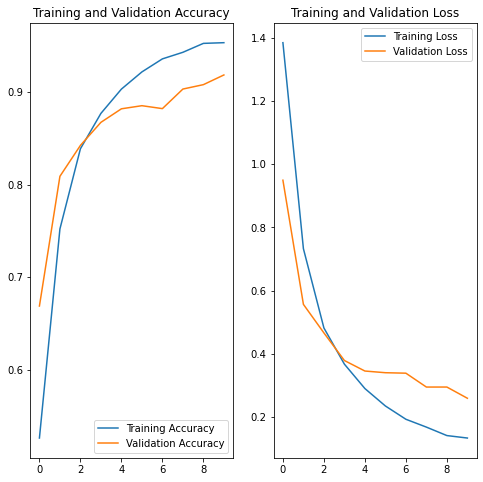

-------------model 2-------------


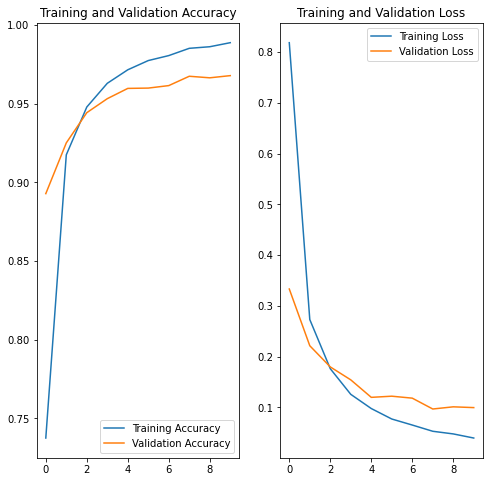

In [13]:
def draw_graph(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs_range = range(len(acc))
    
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()


print('-------------model 1-------------')
draw_graph(history_wav)
print('-------------model 2-------------')
draw_graph(history_wav_2)

### 7. Evaluation 평가
- 저장한 weight 불러오기
- 모델의 예측값과 정답값이 얼마나 일치하는지 확인

In [23]:
print('-------------model 1-------------')
model_wav.load_weights(checkpoint_dir1)
results = model_wav.evaluate(test_dataset)

print("loss value: {:.3f}".format(results[0]))             # loss
print("accuracy value: {:.4f}%".format(results[1] * 100))  # accuracy

-------------model 1-------------
159/159 [==============================] - 20s 123ms/step - loss: 0.2819 - accuracy: 0.9107
loss value: 0.282
accuracy value: 91.0707%


In [16]:
print('-------------model 2-------------')
model_wav_x2.load_weights(checkpoint_dir)
results2 = model_wav_x2.evaluate(test_dataset)

print("loss value: {:.3f}".format(results2[0]))             # loss
print("accuracy value: {:.4f}%".format(results2[1] * 100))  # accuracy

-------------model 2-------------
159/159 [==============================] - 25s 159ms/step - loss: 0.0967 - accuracy: 0.9674
loss value: 0.097
accuracy value: 96.7404%


<br><br><br><br><br><br>

## 회고
### 이번 프로젝트에서 **어려웠던 점,**
데이터의 shape를 변환시켜주었는데, 어느 부분을 변경시켜서 넣어줘야하는지 감이 잘 오지 않았다. 1차원의 Waveform 데이터를 2차원의 Spectrogram 데이터로 변환해주었는데, 또 reshape해주어야하는지 아직 이해하지 못했다. Spectrogram만 진행하고 reshape를 하지 않고 layer input shape에 (130,126)형태로 넣어줬는데도 잘 동작은 되었다. 그래서 더욱 이해가 되지 않는 부분이다. 
```python
# before
sr = 8000
input_tensor = layers.Input(shape=(sr, 1))
# after
input_tensor = layers.Input(shape=(130, 126, 1))
```

### 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
- Sequential API vs Functional API
  - Sequential API는 단순하고 직관적이지만 복잡한 모델을 구성할 수 없다고 한다.
  - Functional API는 모델을 각각 만들어 합치거나 어떤 층을 공유하는 등 복잡한 모델을 구현할 수 있다고 한다.
- 위에도 언급했듯이 아직 shape에 대한 개념이 아직 모호한 것 같다. 그래서 아직 reshape된  

### 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.
1. 1차원의 Waveform 데이터를 2차원의 Spectrogram 데이터로 변환해주었다.
2. Conv1D모델에서 Skip-Connection을 적용한 Conv2D모델을 적용해보았다.
  - Conv1D : loss: 0.2819 - accuracy: 0.9107
  - Conv2D : loss: 0.0967 - accuracy: 0.9674
  
  
### 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**.
Validation과 Train의 accuracy와 loss의 그래프를 보았을 때 차이가 나는 것은 dataset을 나눌 때 0.1로 나누어줬기 때문에 약간의 오버피팅이 나지 않았을까 생각한다.

### **자기 다짐**
numpy공부 좀 해야겠다...